In [11]:
!pip install tensorflowjs

In [12]:
!pip install tensorflow==2.15.0

In [13]:
!pip3 install tensorflow_decision_forests==1.8.1

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
data = pd.read_csv("/content/drive/MyDrive/Bangkit/NLP/dataset/cleaned_labeled_augmen(1).txt", sep=":", names=["job_title", "label"])

In [17]:
#reporsesing data
data['label'] = data['label'].str.strip()
data['job_title'] = data['job_title'].str.lower()
data['job_title'] = data['job_title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data['job_title'] = data['job_title'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# menghilangkan job yang kosong
data = data[data['job_title'] != '']

# Encode label
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# cek data
print(data.head())
print(label_encoder.classes_)


                                       job_title  label
0  segera bergabung sebagai staff dapur produksi      1
1          kami membutuhkan judi online operator      0
2                 dibuka lowongan penjaga warung      1
3                    butuh cepat ao funding dana      1
4                 dibuka lowongan jasa naik rank      1
['illegal' 'legal']


In [18]:
# Features dan labels
X = data['job_title']
y = data['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print sample data
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))
print(data['label'].value_counts())


Train samples: 3405
Test samples: 379


In [19]:
# Define TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=10000,
    output_sequence_length=50
)

# Adapt vectorizer untuk training data
vectorize_layer.adapt(X_train)

# Vectorize  data
train_sequences = vectorize_layer(X_train)
test_sequences = vectorize_layer(X_test)

# Convert ke TensorFlow Dataset
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences, y_train))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences, y_test))

# Batch dan prefetch datasets
BATCH_SIZE = 32
train_dataset = (train_dataset_vectorized.shuffle(1000)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.AUTOTUNE))

test_dataset = (test_dataset_vectorized.batch(BATCH_SIZE)
                                       .prefetch(tf.data.AUTOTUNE))


In [20]:
# model
model = tf.keras.models.Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Membangun model untuk memastikan dimensi input yang benar
model.build(input_shape=(None, 50))


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# menampilkan structure model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1715841 (6.55 MB)
Trainable params: 171584

In [21]:
# melalakukan class weights unutk mengatasi data imbalance
class_weight = {
    0: len(y) / (2 * y.value_counts()[0]),
    1: len(y) / (2 * y.value_counts()[1])
}

# Train model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    class_weight=class_weight
)


Epoch 1/10
107/107 [==============================] - 81s 500ms/step - loss: 0.9233 - accuracy: 0.7319 - val_loss: 0.3395 - val_accuracy: 0.9499
Epoch 2/10
107/107 [==============================] - 44s 416ms/step - loss: 0.2110 - accuracy: 0.9706 - val_loss: 0.1738 - val_accuracy: 0.9525
Epoch 3/10
107/107 [==============================] - 41s 384ms/step - loss: 0.1074 - accuracy: 0.9733 - val_loss: 0.0788 - val_accuracy: 0.9894
Epoch 4/10
107/107 [==============================] - 39s 366ms/step - loss: 0.0840 - accuracy: 0.9906 - val_loss: 0.0505 - val_accuracy: 0.9894
Epoch 5/10
107/107 [==============================] - 42s 393ms/step - loss: 0.0300 - accuracy: 0.9985 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 6/10
107/107 [==============================] - 43s 401ms/step - loss: 0.0838 - accuracy: 0.9794 - val_loss: 0.0791 - val_accuracy: 0.9710
Epoch 7/10
107/107 [==============================] - 39s 361ms/step - loss: 0.0548 - accuracy: 0.9930 - val_loss: 0.1146 - val_ac

In [22]:
# Save model format h5
model.save("saved_model.h5", save_format="h5")


from tensorflow.keras.models import load_model
loaded_model = load_model("saved_model.h5")
print(loaded_model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1715841 (6.55 MB)
Trainable params: 171584

In [23]:
vocab = vectorize_layer.get_vocabulary()
with open('vocab.txt', 'w') as f:
    for word in vocab:
        f.write(f"{word}\n")
print(vectorize_layer.get_vocabulary()[:10])



['', '[UNK]', 'lowongan', 'segera', 'dibuka', 'staff', 'dicari', 'membutuhkan', 'kami', 'admin']


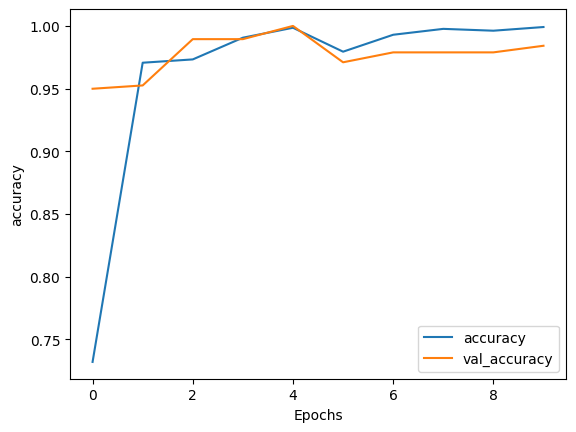

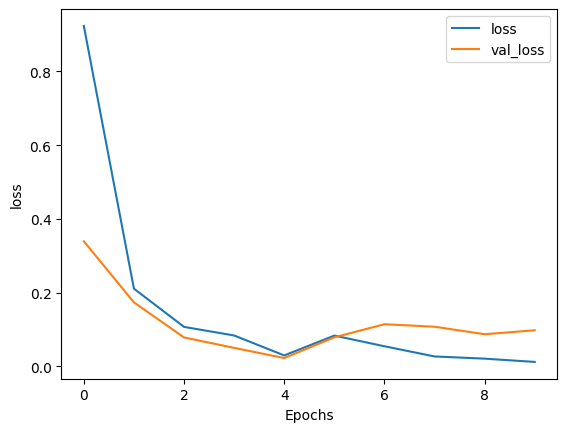

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
loaded_model = tf.keras.models.load_model('saved_model.h5')

new_jobs = ["di cari bunuh dosen baik"]
new_jobs_sequences = vectorize_layer(new_jobs)

predictions = loaded_model.predict(new_jobs_sequences)

threshold = 0.5
for job, prediction in zip(new_jobs, predictions):
    label = "Legal" if prediction[0] >= threshold else "Illegal"
    print(f"Pekerjaan: {job} - Kategori: {label} (Confidence: {prediction[0]:.2f})")

1/1 [==============================] - 2s 2s/step
Pekerjaan: di cari bunuh dosen baik - Kategori: Illegal (Confidence: 0.00)


In [26]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

y_test_array = tf.concat([y for x, y in test_dataset], axis=0).numpy()

precision = precision_score(y_test_array, y_pred)
recall = recall_score(y_test_array, y_pred)
f1 = f1_score(y_test_array, y_pred)

report = classification_report(y_test_array, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

12/12 [==============================] - 4s 125ms/step
Classification Report:
               precision    recall  f1-score   support

     illegal       0.86      1.00      0.93        37
       legal       1.00      0.98      0.99       342

    accuracy                           0.98       379
   macro avg       0.93      0.99      0.96       379
weighted avg       0.99      0.98      0.98       379

Precision: 1.00
Recall: 0.98
F1-Score: 0.99


In [27]:
#import tensorflow as tf
#import tensorflowjs as tfjs
#model.save("sample_data/tf_model/tf_keras.h5")

#tfjs.converters.save_keras_model(model, "sample_data/tfjs_model_keras")

In [28]:
!tensorflowjs_converter --input_format=keras saved_model.h5 sample_data/tfjs_modelnlp2_tf

2024-12-04 04:11:48.800488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 04:11:48.800618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 04:11:48.805209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 04:11:50.378277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
#model.build(input_shape=(None, 20))  # Pastikan input sudah terdefinisi
#model.save('saved_model_complete.h5')  # Simpan model setelah dibangun

In [30]:
#!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model saved_model_complete.h5 tfjs_model_NLP
#!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model saved_model.h5 tfjs_model_NLP



In [31]:
# Convert the model to TensorFlow.js format
#!tensorflowjs_converter --input_format keras saved_model.h5 tfjs_model6_dir

# Verify the output
#!ls tfjs_model6_dir

In [32]:
#!zip -r tfjs_model_NLP.zip tfjs_model_NLP
#from google.colab import files
#files.download('tfjs_model_NLP.zip')

In [33]:
#tensorflowjs_converter --input_format keras model_complete.h5 tfjs_model2_dir


In [34]:
#model.save("saved_model_dir.keras")  # Menyimpan dengan ekstensi .keras



In [35]:
#loaded_model = tf.keras.models.load_model("saved_model_dir.keras")
#loaded_model.summary()


In [36]:
#!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model_dir.keras tfjs_model_NLP
